In [7]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm


Model Performance Metrics with Forward Validation:
R-squared Score: 0.9931
Root Mean Square Error (RMSE): 86.0098
Mean Absolute Error: 40.5878
Mean Prediction Accuracy: 97.92%


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


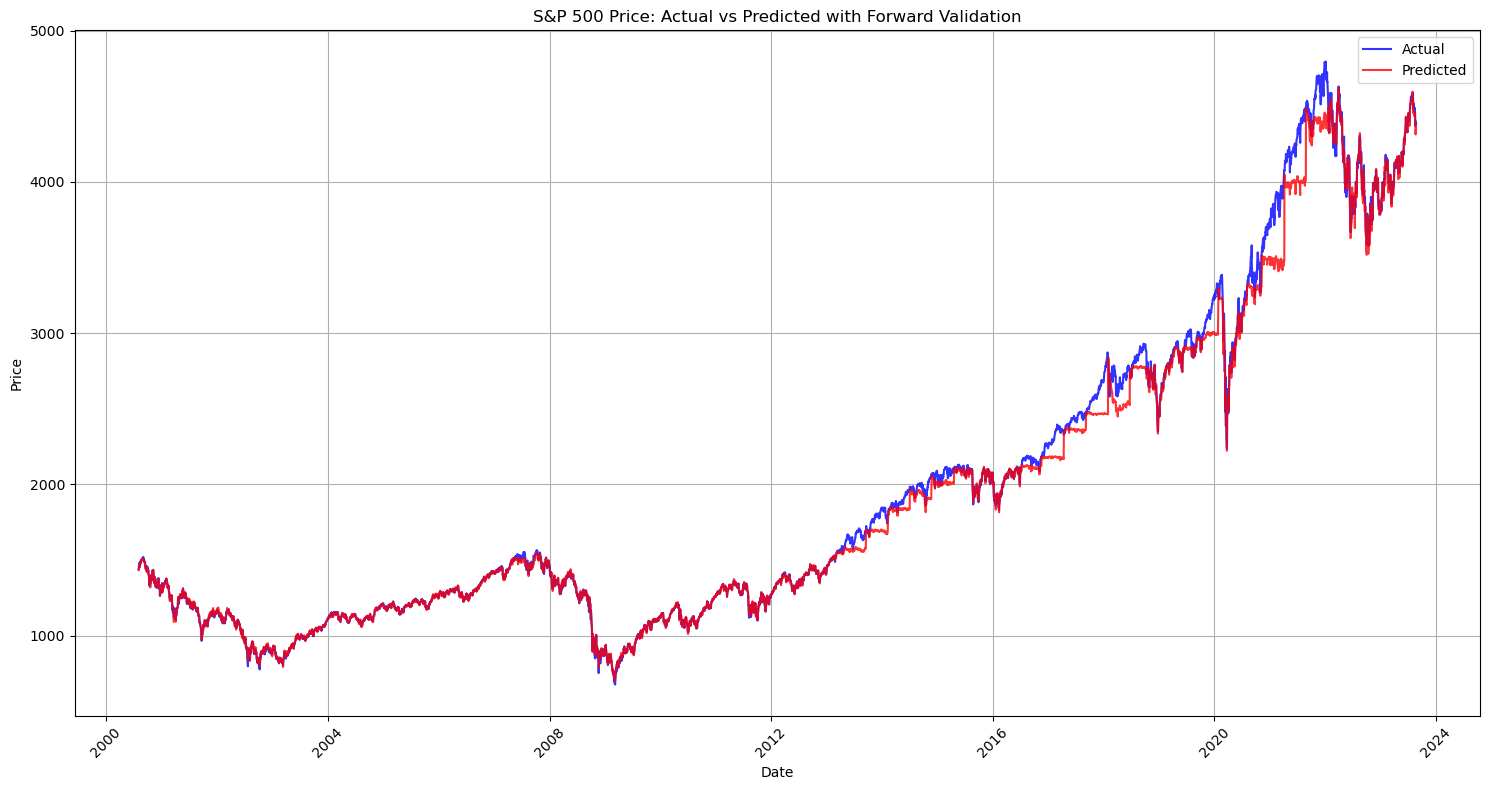

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have v

Date: 2024-01-01, Predicted Close: 3845.26, Percentage Change: -19.383726%
Date: 2024-01-02, Predicted Close: 3845.21, Percentage Change: -0.001327%
Date: 2024-01-03, Predicted Close: 3845.21, Percentage Change: 0.000108%
Date: 2024-01-04, Predicted Close: 3845.21, Percentage Change: -0.000146%
Date: 2024-01-05, Predicted Close: 3845.18, Percentage Change: -0.000724%
Date: 2024-01-08, Predicted Close: 3845.18, Percentage Change: 0.000083%
Date: 2024-01-09, Predicted Close: 3845.16, Percentage Change: -0.000616%
Date: 2024-01-10, Predicted Close: 3845.17, Percentage Change: 0.000298%
Date: 2024-01-11, Predicted Close: 3845.18, Percentage Change: 0.000178%
Date: 2024-01-12, Predicted Close: 3845.15, Percentage Change: -0.000603%
Date: 2024-01-15, Predicted Close: 3844.96, Percentage Change: -0.004914%
Date: 2024-01-16, Predicted Close: 3845.03, Percentage Change: 0.001581%
Date: 2024-01-17, Predicted Close: 3845.13, Percentage Change: 0.002679%
Date: 2024-01-18, Predicted Close: 3845.14,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


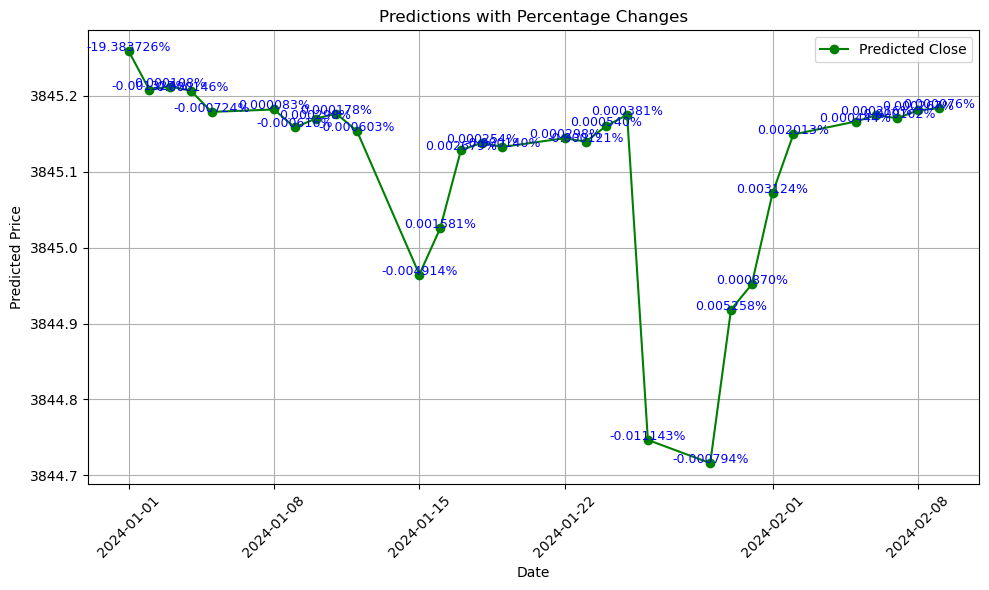

In [19]:
# Load the dataset
df = pd.read_csv('SP500_with_indicators_^GSPC.csv')  # Replace with your dataset file name
df['Date'] = pd.to_datetime(df['Date'])  # Ensure 'Date' is in datetime format
df.set_index('Date', inplace=True)  # Set 'Date' as the index

# Features and target
features = ['Open', 'High', 'Low', 'Volume', 'ATR', 'ADX', 'RSI', 'MACD', 'MACD_Signal', 'Volatility', 'Max_Drawdown']
target = 'Close'

X = df[features]
y = df[target]

# Normalize the features for better model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Forward Validation Function
def forward_validation(df, features, target, initial_train_size, step_size, model_params):
    """
    Perform forward validation for time-series data.
    """
    predictions = []
    actuals = []
    dates = []
    n_splits = (len(df) - initial_train_size) // step_size

    for i in range(n_splits):
        train_start = 0
        train_end = initial_train_size + i * step_size
        test_start = train_end
        test_end = test_start + step_size

        X_train, y_train = df[features].iloc[train_start:train_end], df[target].iloc[train_start:train_end]
        X_test, y_test = df[features].iloc[test_start:test_end], df[target].iloc[test_start:test_end]
        dates.extend(df.index[test_start:test_end])

        # Train the model
        model = xgb.XGBRegressor(**model_params)
        model.fit(X_train, y_train)

        # Predict on the test set
        preds = model.predict(X_test)
        predictions.extend(preds)
        actuals.extend(y_test)

    return predictions, actuals, dates, model

# Define forward validation parameters
initial_train_size = 1000  # Initial training set size
step_size = 100  # Step size for moving train-test splits
model_params = {"n_estimators": 500, "learning_rate": 0.1, "max_depth": 5, "random_state": 42}

# Perform forward validation
predictions, actuals, dates, model = forward_validation(df, features, target, initial_train_size, step_size, model_params)

# Calculate performance metrics
test_rmse = mean_squared_error(actuals, predictions, squared=False)
test_r2 = r2_score(actuals, predictions)
test_mae = mean_absolute_error(actuals, predictions)

mean_prediction_accuracy = 100 * (1 - test_mae / np.mean(actuals))

print("\nModel Performance Metrics with Forward Validation:")
print(f"R-squared Score: {test_r2:.4f}")
print(f"Root Mean Square Error (RMSE): {test_rmse:.4f}")
print(f"Mean Absolute Error: {test_mae:.4f}")
print(f"Mean Prediction Accuracy: {mean_prediction_accuracy:.2f}%")

# Plot actual vs predicted values
plt.figure(figsize=(15, 8))
plt.plot(dates, actuals, label='Actual', color='blue', alpha=0.8)
plt.plot(dates, predictions, label='Predicted', color='red', alpha=0.8)
plt.title('S&P 500 Price: Actual vs Predicted with Forward Validation')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Predict the next week's closing prices
future_steps = 30  # Predict for the next 5 business days (1 week)
future_predictions = []
past_days = 252  # Use the past 252 days to predict the next day
percentage_changes = []

for step in range(future_steps):
    # Use the last `past_days` rows of features for training
    X_train = X.iloc[-past_days:].values
    y_train = y.iloc[-past_days:].values

    # Train a new model on this training set
    model = xgb.XGBRegressor(**model_params)
    model.fit(X_train, y_train)

    # Predict the next day
    current_features = scaler.transform(X.iloc[-1:].values)  # Scale the current features
    next_pred = model.predict(current_features)[0]
    future_predictions.append(next_pred)

    # Calculate percentage change
    if step == 0:
        last_day_close = y.iloc[-1]  # The last actual closing price
    else:
        last_day_close = future_predictions[-2]  # The previous day's prediction

    percentage_change = ((next_pred - last_day_close) / last_day_close) * 100
    percentage_changes.append(percentage_change)

    # Update lag features dynamically
    new_row = current_features.flatten()
    new_row[-1] = next_pred  # Replace the last feature with the prediction
    new_row_df = pd.DataFrame([new_row], columns=X.columns, index=[y.index[-1] + pd.Timedelta(days=1)])
    X = pd.concat([X, new_row_df])

    # Append to target set
    new_y = pd.Series([next_pred], index=[y.index[-1] + pd.Timedelta(days=1)])
    y = pd.concat([y, new_y])

# Generate future dates for the next week
future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='B')

# Print predictions and percentage changes for the next week
for date, prediction, change in zip(future_dates, future_predictions, percentage_changes):
    print(f"Date: {date.date()}, Predicted Close: {prediction:.2f}, Percentage Change: {change:.6f}%")

# Plot future predictions with percentage changes
plt.figure(figsize=(10, 6))
plt.plot(future_dates, future_predictions, marker='o', label='Predicted Close', color='green')
for i, (date, change) in enumerate(zip(future_dates, percentage_changes)):
    plt.text(date, future_predictions[i], f"{change:.6f}%", fontsize=9, ha='center', color='blue')
plt.title('Predictions with Percentage Changes')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()